In [1]:
%pylab inline
import pandas as pd
from sys import platform
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from geopy.geocoders import Nominatim
import folium

if platform == "win32":
    path = 'C:/Users/olive/GitHub/f1-analytics/'
elif platform == "darwin":
    path = '~/Documents/GitHub/f1-analytics/'
    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
### Load race and mereged DataFrames

data = pd.read_csv(path + 'data/results.csv')
merged = pd.read_csv(path + 'data/merged.csv')

In [30]:
incidents = data.query(
    'status != "Finished"'
).status.value_counts()

### Only car statuses that did not finish race are included
incidents = incidents[~incidents.index.str.contains('Lap')]

incidents


[]

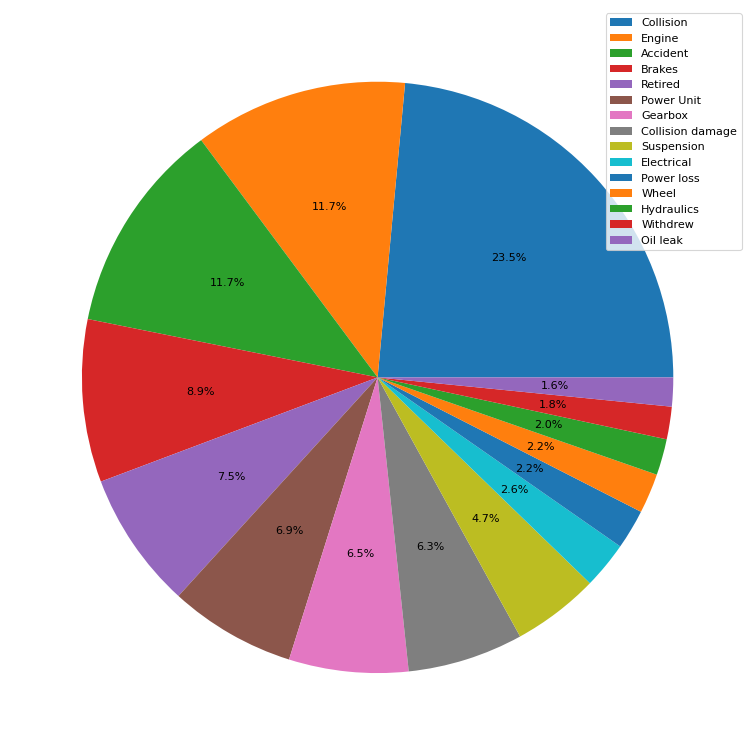

In [56]:
top_incidents = incidents[:15]

fig, axs = plt.subplots(1, dpi=80)
fig.set_size_inches(15, 12)

axs.set_title('')
axs.pie(top_incidents.values, autopct='%1.1f%%')
axs.legend(top_incidents.index, loc=1)
plt.plot()